### Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats as st
data = pd.read_csv('/datasets/games.csv')
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


### Вывод

В глаза бросается только год в неудобном формате, NaN-ы, игры с нулевыми продажами. С этим и будем работать

### Шаг 2. Подготовьте данные

In [2]:
data.columns = data.columns.str.lower()

data['year_of_release'] = data['year_of_release'].fillna(-1)
data['critic_score'] = data['critic_score'].fillna(-1)
data['user_score'] = data['user_score'].fillna(-1)
data['rating'] = data['rating'].fillna('None')

data['user_score'] = data['user_score'].replace('tbd', -1)

data['critic_score'] = data['critic_score'].astype('int')
data['year_of_release'] = data['year_of_release'].astype('int')
data['user_score'] = data['user_score'].astype('float')

data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

data


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,None,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,None,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1,-1.0,None,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-1,-1.0,None,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1,-1.0,None,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,-1,-1.0,None,0.01


### Вывод

Названия столбцов привела к нижнему регистру, играм без даты я заменила пропуск на -1:  ладно бы их было 30 штук- медленно, но верно я бы восстановила эти данные вручную, но их там 267 штук. Так как другие данные из этих строк нам могут пригодиться, я их пометила. Аналогично пометила пропуски в оценке критиков и пользователей. Пропуски в рейтинге заменила на None.

Аббревиатура "tbd" нагуглилась как "To Be Determined", т.е. "будет определено, ожидает определения". Я проверила по срезу -  у всех этих игр очень плохо с продажами и есть вероятность, что определения своего рейтинга среди юзеров они не дождутся -  люди не купили эти игры настолько много, чтобы система смогла рассчитать общий пользовательский рейтинг -такое вот у меня предположение. Заменяю аббревиатуру на -1, как игры без рейтинга.

Добавила столбец с суммарными продажами во всех регионах, в столбце critic_score отбросила нули - везде часть после точки равна нулю, он смысла не несёт.

### Шаг 3. Проведите исследовательский анализ данных

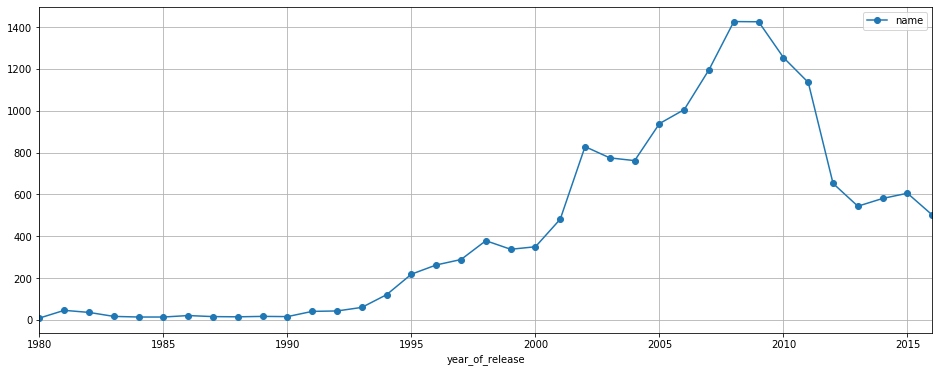

In [3]:
data_years_pivot = data.pivot_table(index = 'year_of_release', values = 'name', aggfunc= 'count').plot(style='o-', grid=True,xlim = (1980, 2016),figsize=(16, 6))


Больше всего игр выпускалось в 2004-2012 годах. В 2016 году мы находились приблизительно на уровне 2001 года.

          total_sales
platform             
PS2           1255.77
X360           971.42
PS3            939.65
Wii            907.51
DS             806.12
PS             730.86
GBA            317.85
PS4            314.14
PSP            294.05
PC             259.52
3DS            259.00
XB             257.74
GB             255.46
NES            251.05
N64            218.68
SNES           200.04
GC             198.93
XOne           159.32
2600            96.98
WiiU            82.19
PSV             54.07
SAT             33.59
GEN             30.77
DC              15.95
SCD              1.86
NG               1.44
WS               1.42
TG16             0.16
3DO              0.10
GG               0.04
PCFX             0.03


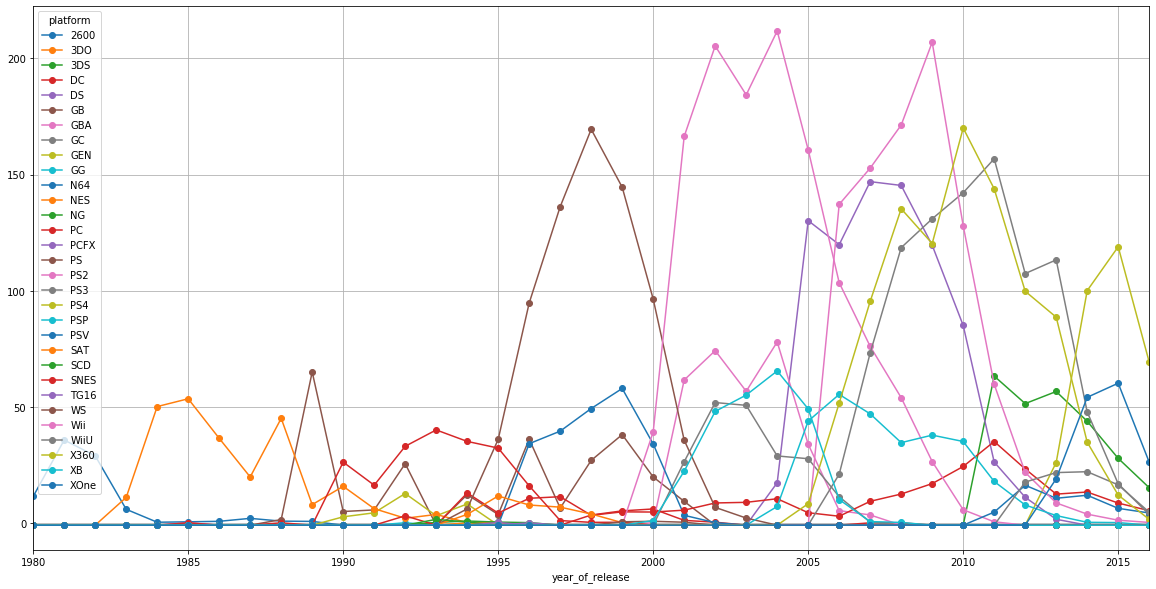

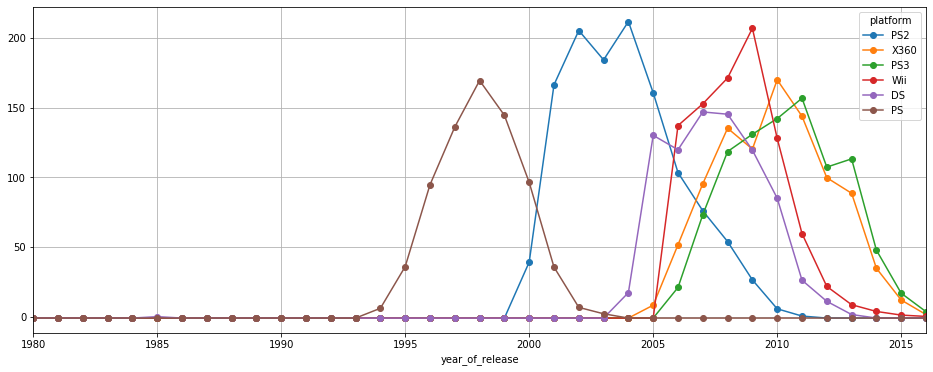

In [4]:
#выявляем самые популярные платформы
sales_on_platforms = data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by ='total_sales', ascending=False)
print(sales_on_platforms)

#строим графики: все платформы и самые популярные
sales_stat = data.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum').fillna(-1)
sales_stat_top = sales_stat.loc[:, ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']]
#print(sales_stat_top)
sales_stat.plot(style='o-', grid=True,xlim = (1980, 2016),figsize=(20, 10))
sales_stat_top.plot(style='o-', grid=True,xlim = (1980, 2016),figsize=(16, 6))

Если говорить о самых популярных платформах, а их у нас 6 штук, то их жизненый цикл длится около 9 - 10 лет. Я построила график по продажам по всем платформам, и ниже - по топ-6 наших платформ. Глядя на эти графики, за актуальный период возьмем данные 2010-2016 года: платформы, выбывшие из гонки ранее, нам не интересны, однако, такой период позволяет наблюдать тенденцию развития актуальных платформ.

Тогда теперь пересмотрим наш топ, добавив туда только платформы с наибольшей выручкой только за актуальный период:

          total_sales
platform             
PS3            587.74
X360           550.41
PS4            314.14
3DS            257.81
Wii            222.97
XOne           159.32
DS             123.75
PC             121.96
WiiU            82.19
PSP             64.05
PSV             53.81
PS2              6.09


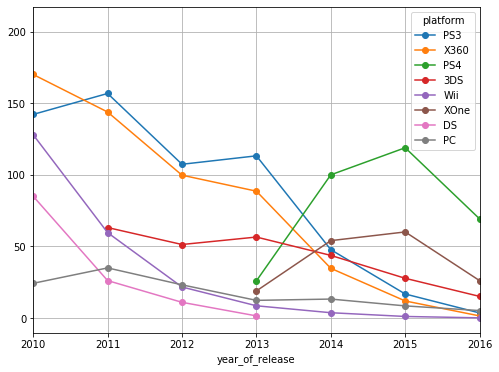

In [5]:
new_sales_stat = data.query('year_of_release >= 2010').pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by ='total_sales', ascending=False)
print(new_sales_stat)
new_sales_stat_top = data.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
new_sales_stat_top = new_sales_stat_top.loc[:, ['PS3', 'X360', 'PS4', '3DS', 'Wii', 'XOne', 'DS', 'PC']]
new_sales_stat_top.plot(style='o-', grid=True,xlim = (2010, 2016),figsize=(8, 6))

Я отобрала платформы, где суммарные продажи превышают 100 миллионов долларов (8 шт). У всех платформ за актуальный период отрицательная динамика, однако, это не говорит о том, что выбранные платформы убыточные сами по себе. Если взглянуть на два графика выше, можно заметить, что в целом идёт тенденция снижения популярности игр на платформах из списка, а новых нет.

Наиболее прибыльными за актуальный период я считаю платформы PS4, XOne, PS3:

In [6]:
data = data.query('platform == "PS3" | platform == "X360" | platform == "PS4" | platform == "3DS" | platform == "Wii" | platform == "XOne" | platform == "DS" | platform == "PC"')
data = data.query('year_of_release >= 2010')
data.pivot_table(index='platform', values= 'total_sales', aggfunc='sum').sort_values(by ='total_sales', ascending=False)


,total_sales
platform,
PS3,587.74
X360,550.41
PS4,314.14
3DS,257.81
Wii,222.97
XOne,159.32
DS,123.75
PC,121.96


For PS3
count    141.000000
mean       2.735745
std        2.828534
min        1.020000
25%        1.270000
50%        1.740000
75%        2.810000
max       21.050000
Name: total_sales, dtype: float64


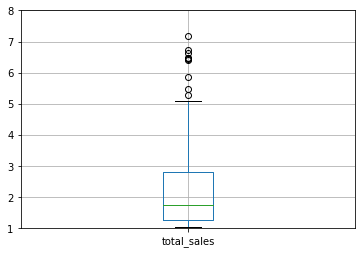

For X360
count    131.000000
mean       3.034733
std        3.287218
min        1.010000
25%        1.355000
50%        1.940000
75%        3.025000
max       21.820000
Name: total_sales, dtype: float64


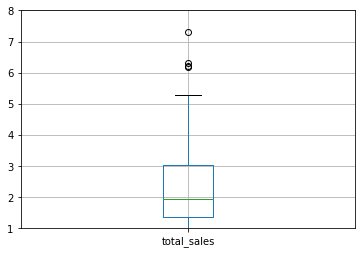

For PS4
count    78.000000
mean      3.123205
std       2.467599
min       1.020000
25%       1.667500
50%       2.165000
75%       3.937500
max      14.630000
Name: total_sales, dtype: float64


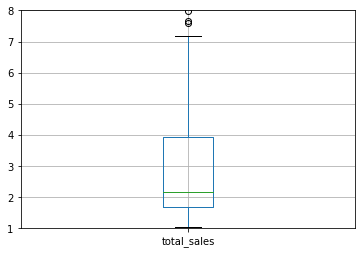

For 3DS
count    48.000000
mean      3.563958
std       3.405597
min       1.010000
25%       1.387500
50%       2.075000
75%       3.860000
max      14.600000
Name: total_sales, dtype: float64


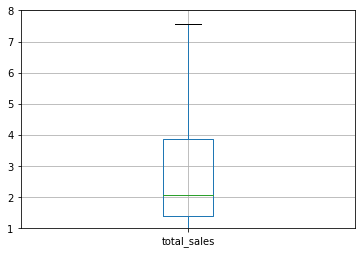

For Wii
count    41.000000
mean      3.109024
std       2.410142
min       1.020000
25%       1.540000
50%       2.150000
75%       3.580000
max      10.120000
Name: total_sales, dtype: float64


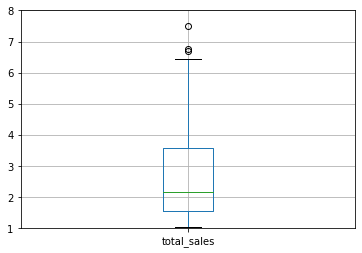

For XOne
count    51.000000
mean      2.252941
std       1.321960
min       1.030000
25%       1.320000
50%       1.730000
75%       2.840000
max       7.390000
Name: total_sales, dtype: float64


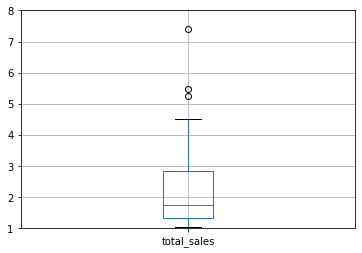

For DS
count    20.000000
mean      2.560500
std       3.332244
min       1.020000
25%       1.197500
50%       1.455000
75%       2.115000
max      15.130000
Name: total_sales, dtype: float64


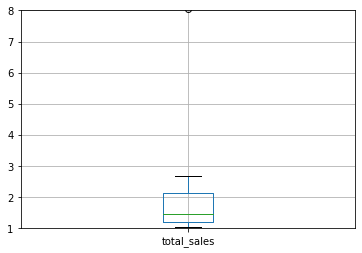

For PC
count    25.000000
mean      2.064000
std       1.118846
min       1.160000
25%       1.360000
50%       1.670000
75%       2.300000
max       5.140000
Name: total_sales, dtype: float64


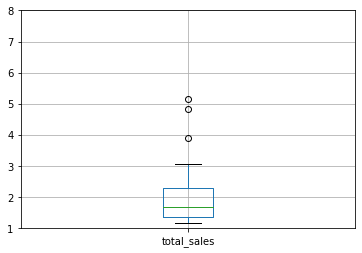

In [7]:
for value in ['PS3', 'X360', 'PS4', '3DS', 'Wii', 'XOne', 'DS', 'PC']:
    analysis = data.query('platform == @value & total_sales > 1')
    print('For',value)
    print(analysis['total_sales'].describe())
    analysis.boxplot('total_sales')
    plt.ylim(1,8)
    plt.show()


Медианные значения продаж на платформе PS3 стремятся к 1, однако, бывают и крупные продажи. Медианное значение для X360 выше, но верхний ус такой же - необычно большие продажи так же часто, а вот средний чек больше. Четвертая плойка начала свой путь только в 2013 году, за один год поднявшись на первое место по продажам. Отсюда и такое высокое значение Q1, нижней грани ящика. Медиана у неё стремится вниз - снова медианные продажи небольшие. зато правый ус длинный - тут можно продвигать дорогие игры.

У платформы 3DS самый длинный ус из всех, что пока встретили -  есть продажи, существенно выше средних. Платформа Wii имеет не самую маленькую медиану, но крупных продаж у неё меньше чем у PS4 или 3DS. У XOne медианное значение смещено вниз и ус короткий - это достаточно свежая платформа и находится на втором месте нашего топа по продажам. Возможно, ей нужно ещё времени.

Последние две платформы DS и PC достаточно похожи: медианный заказ ниже среднего, правый(верхний) ус короткий. Разве что DS "сдулась" к 2013-му, и из датасета её я исключаю в дальнейшем.

В целом, я думаю, что рекламировать дорогие продукты стоит на платформах PS4,3DS и Wii. На остальных платформах рынок более устоявшийся, там лучше зайдут продукты подешевле. Самый непонятный рынок - на XOne, но опять же, он молодой, может, изменится со временем, но на 2017 я бы его советовала рассмаривать как канал продаж только недорогих игр. Для недорогих игр также можно рассмотреть PS3.

In [8]:
#убираю платформу DS
data = data.query('platform == "PS3" | platform == "X360" | platform == "PS4" | platform == "3DS" | platform == "Wii" | platform == "XOne" | platform == "PC"')
data 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88,3.4,M,14.73
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,None,14.63
...,...,...,...,...,...,...,...,...,...,...,...,...
16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0.00,0.00,0.01,0.00,-1,-1.0,None,0.01
16692,Metal Gear Solid V: Ground Zeroes,PC,2014,Action,0.00,0.01,0.00,0.00,80,7.6,M,0.01
16696,Breach,PC,2011,Shooter,0.01,0.00,0.00,0.00,61,5.8,T,0.01
16702,STORM: Frontline Nation,PC,2011,Strategy,0.00,0.01,0.00,0.00,60,7.2,E10+,0.01


for PS3
0.15211357648702


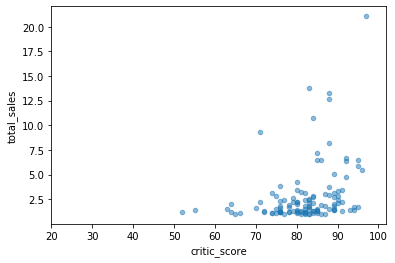

for X360
0.12844983112691433


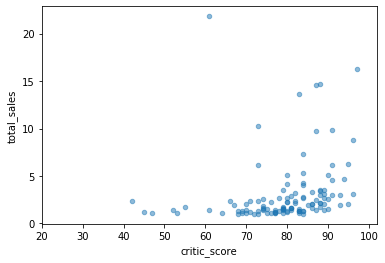

for PS4
-0.01996223657412285


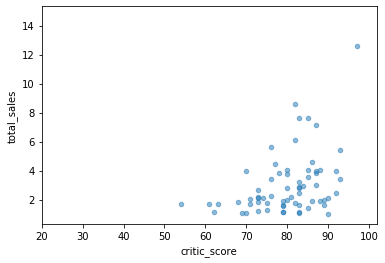

for 3DS
0.011361305133986529


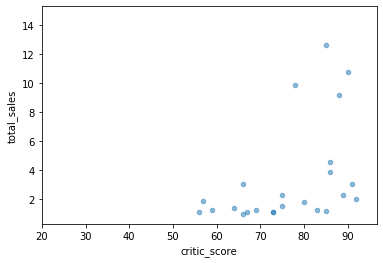

for Wii
0.24904979935765906


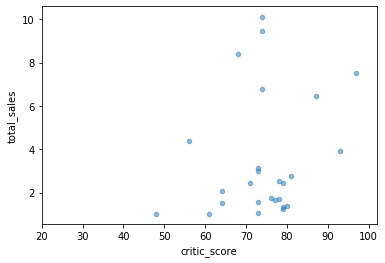

for XOne
-0.2642745824768445


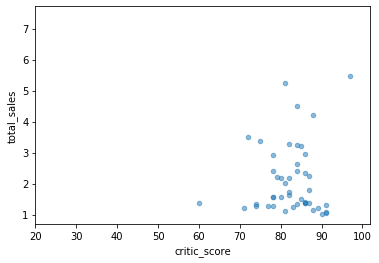

for PC
0.2691370572687946


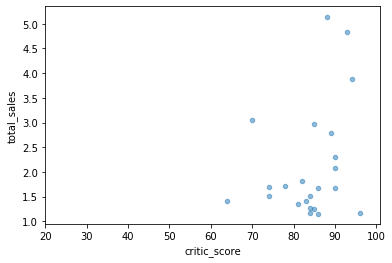

In [9]:
for value in ['PS3', 'X360', 'PS4', '3DS', 'Wii', 'XOne', 'PC']:
    result = data.query('platform == @value & total_sales > 1')
    print('for', value)
    print(result['critic_score'].corr(result['total_sales']))
    result.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5, xlim = 20)
    plt.show()

Нельзя сказать о наличии значительной корреляции между продажами и количеством отзывов. Но можно отметить, что есть зависимость между количеством отзывов и наличием продаж - нет отзывов, нет продаж. На PS3 и X360 отзывов больше всего - их можно изучить разработчикам и маркетологам, чтобы не бегать по разным платформам.

for PS3
-0.010463683300403688


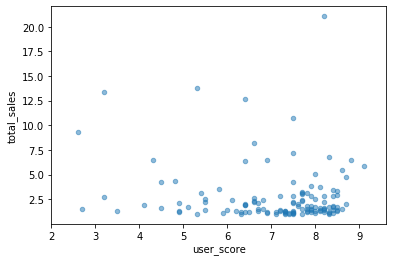

for X360
-0.04223241531528038


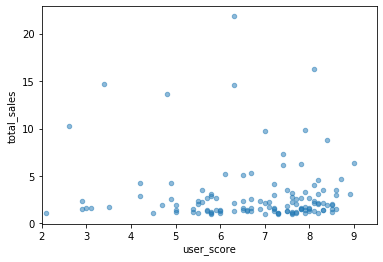

for PS4
-0.132214661867956


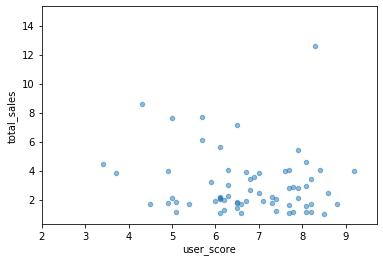

for 3DS
-0.029483633728643797


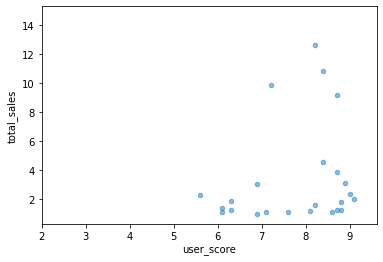

for Wii
0.20298014557973734


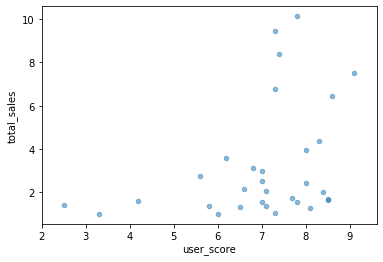

for XOne
-0.4750420849720365


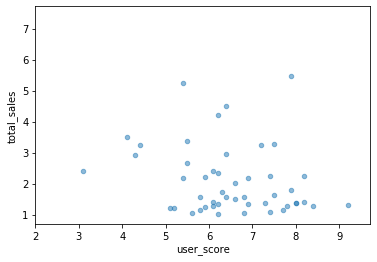

for PC
0.12010539339030984


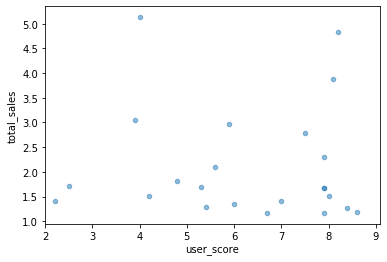

In [10]:
for value in ['PS3', 'X360', 'PS4', '3DS', 'Wii', 'XOne', 'PC']:
    result = data.query('platform == @value & total_sales > 1')
    print('for', value)
    print(result['user_score'].corr(result['total_sales']))
    result.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5, xlim = 2)
    plt.show()

С оценкой юзеров ситуация обстоит похожая- люди ставят чаще всего оценку выше среднего, либо не ставят вовсе. Корреляция также незначительна, но кроме платформы XOne: корреляция равна -0.47, и сильно выбивается из всех значений корреляции.

Я пообщалась на эту тему с несколькими любителями компьютерных игр и вот к какому выводу пришла: XOne предлагает уникальные игры, которая разрабатывает Microsoft, в которые не поиграешь на других платформах, поэтому у поклонников определённой игры зачастую нет альтернативной платформы: своебразная монополия, получается. Также, эта платформа менее удобна для программистов - страдает графика, например, а искушенным игрокам есть с чем сравнить качество. Можно сделать вывод, что на платформе продаётся мало качественных игр - при падении суммы продаж отзывов становится только больше (может, игры подешевле и менее качественные, пользователи ожидают большего). Также можно предположить, что на этой платформе покупают чаще всего недорогие игры.


In [11]:
data.pivot_table(index = 'genre', values = 'total_sales', aggfunc= 'sum').sort_values(by ='total_sales', ascending=False)
#data.pivot_table(index = 'rating', values = 'total_sales', aggfunc= 'sum').sort_values(by ='total_sales', ascending=False)

,total_sales
genre,
Action,597.54
Shooter,467.49
Sports,306.00
Role-Playing,244.18
Misc,195.41
Racing,108.05
Platform,88.40
Fighting,67.43
Simulation,61.40


Достаточно чётко выделяется тройка популярных жанров и тройка аутсайдеров. В топе адреналиновый микс - игры вызывающие у людей азарт и острые ощущения: экшены, шутеры, спортивные игры. 

Замыкают список игры, требуюющие повышенной умественной работы, но спокойные - приключения, стратегии, паззлы. 


### Вывод

Платформы, на которые стоит обратить внимание -  PS4, XOne, 3DS. Рейтинги критиков и юзеров на платформах не сильно влияют на продажи - возможно, популярность приходит извне - стримы и обзоры на других сайтах наверняка распространяют информацию об играх лучше, может, на это и стоит сделать упор в рекламной компании. Наиболее продающиеся жанры - экшены, шутеры, спортивные игры, чем больше игра заставляет человека вовлекаться внутрь происходящего, переживать, тем успешнее она будет. Жанры типа приключений, стратегий, паззлов продаются хуже всех.

### Шаг 4. Составьте портрет пользователя каждого региона

In [12]:
for value in['na_sales','eu_sales', 'jp_sales']:
    print(data.pivot_table(index= 'platform', values=value, aggfunc= 'sum').sort_values(by =value, ascending=False))
    print('')

          na_sales
platform          
X360        334.18
PS3         229.25
Wii         121.20
PS4         108.74
XOne         93.12
3DS          82.65
PC           39.07

          eu_sales
platform          
PS3         213.60
X360        163.41
PS4         141.09
PC           68.82
Wii          65.91
3DS          61.27
XOne         51.59

          jp_sales
platform          
3DS         100.62
PS3          59.26
Wii          17.75
PS4          15.96
X360          5.46
XOne          0.34
PC            0.00



Самый играющий регион -  Северная Америка: её основная платформа обгоняет Европейскую платформу по продажам в полтора раза, а Японскую -  в 3 раза! Топ-5 у европейцев и американцев почти одинаков по составу, только отличаются платформами PC и XOne - европейцы предпочитают компьютер, а американцы XOne. В Японии на первом месте 3DS, хотя в остальных регионах она плетется в конце-  видимо, это платформа, в основном, используется на японском рынке. То, что у японцев меньше продаж, означает, что и игроков там меньше - население Японии равно 124 776 364 чел. против 565 265 000 чел. в Северной Америке (данные из поисковика Яндекс).

Американцы чаще всего используют X360, японцы 3DS, европейцы PS3. Последнюю в целом любят по регионам - она наверху топа везде.

In [13]:
for value in['na_sales','eu_sales', 'jp_sales']:
    print(data.pivot_table(index= 'genre', values=value, aggfunc= 'sum').sort_values(by =value, ascending=False))
    print('')


              na_sales
genre                 
Action          261.24
Shooter         232.16
Sports          149.12
Misc            108.18
Role-Playing     94.95
Platform         40.40
Racing           39.51
Fighting         33.35
Simulation       19.86
Adventure        16.80
Strategy          9.95
Puzzle            2.69

              eu_sales
genre                 
Action          213.16
Shooter         167.80
Sports          110.79
Role-Playing     66.97
Misc             56.13
Racing           49.76
Platform         28.46
Simulation       24.93
Fighting         17.52
Adventure        15.85
Strategy         11.23
Puzzle            3.09

              jp_sales
genre                 
Role-Playing     61.40
Action           53.85
Misc             13.51
Shooter          12.08
Simulation       11.67
Platform         11.51
Sports            9.84
Fighting          9.57
Adventure         5.57
Racing            5.16
Strategy          2.71
Puzzle            2.52



В Европе и Северной Америке вкусы игроков практически идентичны -  топ-5 игр почти одинаковый(экшены, шутеры, спортивные игры, Misc (я не знаю, что это за жанр), ролевые игры), лишь небольшое различие на на последних местах: американцы чуть больше любят Misc, а европейцы - ролевые игры. 

Японцы более миролюбивые - шутеры опустились на четвертое место, а на первое вышли ролевые игры. Полагаю, это связано с популярностью аниме-культуры, косплея, перевоплощений. За счёт смещения шутеров и спортивных игр вниз, в топ-5 попали также симуляции.

In [14]:
for value in['na_sales','eu_sales', 'jp_sales']:
    print(data.pivot_table(index= 'rating', values=value, aggfunc= 'sum').sort_values(by =value, ascending=False))
    print('')

        na_sales
rating          
M         375.18
E         224.33
T         149.37
E10+      132.91
None      125.71
EC          0.71
RP          0.00

        eu_sales
rating          
M         286.89
E         169.52
None      120.20
T         106.44
E10+       82.61
RP          0.03
EC          0.00

        jp_sales
rating          
None       98.83
E          35.30
T          29.58
M          27.55
E10+        8.13
EC          0.00
RP          0.00



Не принимая во внимание None, на всех трёх рынках лидируют рейтинги М, Е, Т. М- категория для взрослых, не подходит для подростков младше 17-ти лет. Я так понимаю, в эту категорию, в основном попадают любимые всеми экшены и шутеры -  из-за реалистичного насилия, крови, ненормативной лексики. Категория Е доступна для всех старше 6ти лет: там разрешено только мягкое насилие, и то в мультипликационной форме. Я думаю, как раз из-за этого категория лидирует в Японии(мультипликационные сцены, аниме, комиксы, и т.д.)

Т- что-то среднеее между этими категориями - в меру грубости, ограниченное насилие, кровь, ненормативная лексика. Она менее популярная в Европе и в Америке, видимо потому, что разработчики выбирают одно из крайних значений -  либо взрослая игра, либо очевидно детская. А может быть, есть сложности с определением степени насилия, откровенности в духе "достаточно ли мультяшно выглядит кровь в этой сцене?". Поэтому проще выбрать более очевидные требования жанров М и Е, чем расплывчатые требования категории Е, где может трактоваться по-разному.

Похоже, что в Японии есть-какие-то сложности с определением жанра, раз None вылез на первое место. Но выбирая рейтинг М или Е, не прогадаем в любом регионе. 

### Вывод

Итак, портреты:
Типичный игрок в Северной Америке: играет много, на платформах X360, PS3 или Wii. Любит экшены, шутеры, спортивные игры, категории M, E, T (особенно первые две).

Типичный игрок в Европе: игроков в Европе меньше, но они предпочитают платформы PS3, X360, PS4 - первые две те же, что в Америке, просто, видимо, рынок платформ исторически сложился в ином порядке. Вкусы в жанрах и рейтингах идентичны предпочтениям американцев.

Японский типичный игрок отличается сильнее: у них своя популярная платформа - 3DS, а потом уже идут знакомые PS3, Wii. Ролевые игры и экшены - в топе популярности по жанрам, следом идёт Misc. В Японии определённо творится что-то непонятное по рейтингам, раз столько игр продаётся без него (или это были игры с абревиатурой tbd). В отличии от европейцев и американцев, японцы больше всего предпочитают категории Е и Т -  я думаю, потому, что под него попадает большинство аниме игр и мирных ролевых игр, а уже потом идёт взрослая категория М.

### Шаг 5. Проверьте гипотезы

#### H0: Средние пользовательские рейтинги платформ Xbox One и PC равны

In [15]:
alpha = .05

data = data.query('user_score > 0')
data = data.query('critic_score > 0')
data = data.query('rating != "None"')


h0_XOne = data.query('platform == "XOne"')
h0_XOne = h0_XOne['user_score']

h0_PC = data.query('platform == "PC"')
h0_PC = h0_PC['user_score']

h0_results = st.ttest_ind(
    h0_XOne, 
    h0_PC)

print('p-значение:', h0_results.pvalue)

if (h0_results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу - рейтинги не равны")
else:
    print("Не получилось отвергнуть нулевую гипотезу - рейтинги равны")

p-значение: 0.9791245115631193
Не получилось отвергнуть нулевую гипотезу - рейтинги равны


#### Проведём другой анализ. H0: Средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports 

In [16]:

alpha = .05

h0_action = data.query('genre == "Action"')
h0_action = h0_action['user_score']

h0_sports = data.query('genre == "Sports"')
h0_sports = h0_sports['user_score']

h0_results = st.ttest_ind(
    h0_action, 
    h0_sports)

print('p-значение:', h0_results.pvalue)

if (h0_results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу - рейтинги не равны")
else:
    print("Не получилось отвергнуть нулевую гипотезу - рейтинги равны")

p-значение: 1.3561569153537016e-08
Отвергаем нулевую гипотезу - рейтинги не равны


### Шаг 6. Напишите общий вывод

Несмотря на то, что европейцы больше предпочитают PC, а американцы XOne, на средний рейтинг это не влияет. Но на рейтинг влияет жанр -  видимо, есть жанры, которые в целом нравятся большинству игроков - таковым является жанр Action, судя по его популярности во всех регионах. 

Можно выявить следующие составляющие успеха игры - размещать игры следует на этих платформах: игры подороже - PS4,3DS и Wii, игры подешевле - XOne, PS3. Ориентироваться на оценки критиков и пользователей смысла нет, видимо, всё очень субъективно. Стоит сделать упор на экшены - они понравятся всем. Для Европы и Северной Америки также стоит вложиться в шутеры и спортивные игры, а в Японии главный тренд - ролевые игры. Игры с рейтингом Е зайдут на всех рынках, но любовь к шутерам у европейцев и американцев также допускает категорию М, а японцы предпочитают игры для подростков(рейтинг Т) и мультипликационные игры.